/tmp/ipykernel_2123/993241185.py:96: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


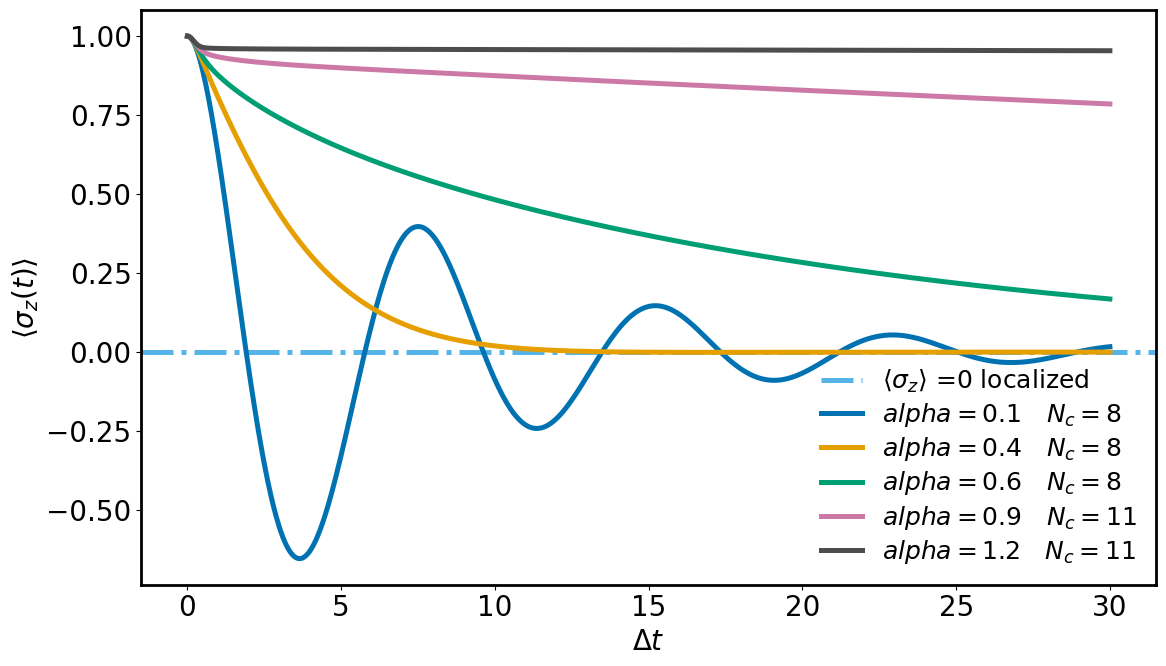

In [24]:

import numpy as np
from matplotlib import pyplot as plt
from mpl_setup import BLUE,ORANGE,GREEN,PURPLE,GRAY,SKY_BLUE,VERMILLION
from qutip import *


from qutip.solver.heom import (
    BosonicBath,
    HEOMSolver,
    CorrelationFitter
)
colors=[BLUE,ORANGE,GREEN,PURPLE,GRAY,SKY_BLUE,VERMILLION]
eps = 0.1   #small system energy

Hsys =  0.5 * eps * sigmax() 
def plot_result_expectations(result,color,label,m_op, axes=None,factor=1):
    """ Plot the expectation values of operators as functions of time.

        Each plot in plots consists of: (solver_result, measurement_operation,
        color, label).
    """
    if axes is None:
        fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 8))
        fig_created = True
    else:
        fig = None
        fig_created = False

    # add kw arguments to each plot if missing
    exp = np.real(expect(result.states, m_op))
    axes.plot(np.array(result.times)*factor, exp, color=color, label=label)

    if fig_created:
        axes.legend(loc=0, fontsize=12)
        axes.set_xlabel("t", fontsize=28)

    return fig


### ALPHA
alphas = [0.1,0.4,0.6,0.9,1.2]
NCs = [8,8,8,11,11]

wc = 1

t = np.linspace(0,50,1000)
T = 0
def J(w,alpha=1):
    """ The Ohmic bath spectral density as a function of w (and the bath parameters). """
    return (np.pi/2)* w * alpha * 1 / (1+(w/wc)**2)**2
Q=sigmaz()
Ttot = 300
# Times to solve for:
tlist = np.linspace(0, Ttot, 1000)
rho0 = basis(2, 0) * basis(2, 0).dag()
try: #Load precomputed models if existing
    models=[qload("transition_"+str(i)) for i in alphas]
except:
    fig, axes = plt.subplots(1, 1, sharex=True, figsize=(12, 7))
    for i in range(len(alphas)):
        bath = BosonicBath(Q, [], [], [], [], T=T)
        bath.spectral_density=lambda w: J(w,alphas[i])
        C=bath.correlation_function(t)
        fc2=CorrelationFitter(Q,0,t,C)
        bath,fitinfo=fc2.get_fit(Ni=1,Nr=3)
        print(fitinfo["summary"])
        plt.plot(t,np.real(bath.correlation_function(t)))
        plt.plot(t,np.real(bath.correlation_function_approx(t)))
        plt.show()
        plt.plot(t,np.imag(bath.correlation_function(t)))
        plt.plot(t,np.imag(bath.correlation_function_approx(t)))
        plt.show()
        options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)
        # Number of levels of the hierarchy to retain:
        NC = NCs[i]  #this is an importance covnergence parameter
        HEOMMats = HEOMSolver(Hsys, [bath], NC, options=options)
        resultMats = HEOMMats.run(rho0, tlist)
        qsave(data=resultMats,name="transition_"+str(alphas[i]))
        models=[qload("transition_"+str(i)) for i in alphas]


fig, axes = plt.subplots(1, 1, sharex=True, figsize=(12, 7))
plt.axhline(y=0, label=r"$\langle \sigma_{z} \rangle$ =0"+ " localized ",color=colors[len(alphas)],linestyle='-.')

for k,i in enumerate(models):
    plot_result_expectations(
        i,colors[k], rf"$alpha={alphas[k]} \quad N_c={NCs[k]}$" ,sigmaz(),axes=axes,factor=eps
    )
#plt.xlim(0,1)
#axes.locator_param
axes.legend(loc=0,fontsize=18)
axes.xaxis.set_tick_params(labelsize=20)
axes.yaxis.set_tick_params(labelsize=20)
plt.ylabel(r"$\langle \sigma_{z}(t) \rangle$",fontsize=20)
plt.xlabel(r"$\Delta t$",fontsize=20)
fig.tight_layout()
plt.savefig('./heom_transition.pdf')
